In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df_SF3 = pd.read_csv( './data/SHARADAR_SF3_ce320d02f19d0b5d04c9557e0bc16680.zip') # read SF3 table

In [3]:
df_SF3 = df_SF3[df_SF3['securitytype'] == 'SHR']

In [4]:
SF3_tickers = df_SF3.ticker.unique()

In [5]:
SF3_investors = df_SF3.investorname.unique()

In [6]:
SF3_dates = pd.to_datetime(df_SF3.calendardate.unique()) # collect dates of investor filings

In [7]:
#unique ('investor', 'ticker') pairs
invstrTckrPair = df_SF3[['investorname', 'ticker']].drop_duplicates()

In [8]:
#unique ('investor', 'ticker') pairs we do not know when initially invested (We should eliminate them when we construct investor-investor graph)
invstrTckrPair1306 = df_SF3.query('calendardate == "2013-06-30"')[['investorname', 'ticker']]

In [9]:
#"new" unique ('investor', 'ticker') pairs from 2013-09-30
invstrTckrPair['common'] = 1
invstrTckrPair1306['common'] = 1
newInvstrTckrPair = invstrTckrPair.merge(invstrTckrPair1306, on=['investorname', 'ticker'], how='left')
newInvstrTckrPair = newInvstrTckrPair[newInvstrTckrPair.common_y.isnull()][['investorname','ticker']]

In [10]:
#Eliminate investors who invest 1000+ stocks
num_invest = newInvstrTckrPair.groupby('investorname').count()
num_invest.columns = ['num_invest']
SF3_investors = np.array(num_invest[num_invest['num_invest'] < 1000].index)

In [11]:
#Construct investor-investor edge list
SF3_dates_rev = SF3_dates.values[::-1]
df_investors = pd.DataFrame(SF3_investors, columns = ['investorname'])
df_investors['investorID'] = df_investors.index
df_investors = df_investors.astype({'investorID':'uint16'})

for t in range(len(SF3_dates_rev)-1):
    #(investor, ticker) pair in quater t and t+1 respectively
    invstrTckrPair1 = df_SF3.query('calendardate == "{}"'.format(str(SF3_dates_rev[t])[:10]))[['investorname', 'ticker']]
    invstrTckrPair1 = pd.merge(invstrTckrPair1, df_investors)[['investorID', 'ticker']]
    invstrTckrPair2 = df_SF3.query('calendardate == "{}"'.format(str(SF3_dates_rev[t+1])[:10]))[['investorname', 'ticker']]
    invstrTckrPair2 = pd.merge(invstrTckrPair2, df_investors)[['investorID', 'ticker']]

    #extract new (investor, ticker) pairs in quater t+1
    invstrTckrPair1['common'] = 1.0
    invstrTckrPair2['common'] = 1.0
    newInvstrTckrPair = invstrTckrPair2.merge(invstrTckrPair1, on=['investorID', 'ticker'], how='left')
    newInvstrTckrPair = newInvstrTckrPair[newInvstrTckrPair.common_y.isnull()][['investorID','ticker']]
    
    if t == 0:
        newInvstrTckrPair['common'] = 1.0
        prevInvstrTckrPair = newInvstrTckrPair
    else:
        #Assign an information weight of each ticker, based on the total number of investment for the ticker in a previous quarter
        #ticker_weight = pd.DataFrame(prevInvstrTckrPair["ticker"].value_counts())
        #ticker_weight["weight"] = 1 / np.sqrt(ticker_weight["ticker"])
        #ticker_weight["ticker"] = ticker_weight.index
        
        #Assign an information weight of each source Investor, based on the total number of investment in a previous quarter
        srcInvestor_weight = pd.DataFrame(prevInvstrTckrPair["investorID"].value_counts())
        srcInvestor_weight["investorID"] = 1 / (srcInvestor_weight["investorID"] + 1)
        srcInvestor_weight = srcInvestor_weight.rename(columns = {'investorID':'src_weight'})
        srcInvestor_weight["investorID_y"] = srcInvestor_weight.index
        
        #Assign an information weight of each distination Investor, based on the total number of investment in a current quarter
        dstInvestor_weight = pd.DataFrame(newInvstrTckrPair["investorID"].value_counts())
        dstInvestor_weight["investorID"] = 1 / (dstInvestor_weight["investorID"] + 1)
        dstInvestor_weight = dstInvestor_weight.rename(columns = {'investorID':'dst_weight'})
        dstInvestor_weight["investorID_x"] = dstInvestor_weight.index
        
        #If any new (investor, ticker) pair in t and in t+1 share same ticker, create edge
        newInvstrTckrPair['common'] = 1.0
        InvstrInvstrPair = newInvstrTckrPair.merge(prevInvstrTckrPair, on=['ticker'], how='left')
        #InvstrInvstrPair = InvstrInvstrPair.merge(ticker_weight, on=['ticker'], how='left')
        InvstrInvstrPair = InvstrInvstrPair.merge(srcInvestor_weight, on=['investorID_y'], how='left')
        InvstrInvstrPair = InvstrInvstrPair.merge(dstInvestor_weight, on=['investorID_x'], how='left')
        
        InvstrInvstrPair = InvstrInvstrPair[InvstrInvstrPair.common_y.notnull()][['investorID_y','investorID_x','src_weight', 'dst_weight']]
        InvstrInvstrPair['weight'] = InvstrInvstrPair['src_weight'] * InvstrInvstrPair['dst_weight'] 
        
        InvstrInvstrPair = InvstrInvstrPair[['investorID_y','investorID_x', 'weight']]
        InvstrInvstrPair = InvstrInvstrPair.astype({'investorID_y':'uint16'})
        InvstrInvstrPair = InvstrInvstrPair.groupby(['investorID_y','investorID_x'], as_index=False)['weight'].sum()

        if t == 1:
            InvstrInvstrPair_accm = InvstrInvstrPair
        else:
            InvstrInvstrPair_accm = pd.concat([InvstrInvstrPair_accm, InvstrInvstrPair], ignore_index=True)
            prevInvstrTckrPair = newInvstrTckrPair

        print('t:', t, ' Num of new (invstr, tckr):',len(newInvstrTckrPair), ' Num of (invstr(t-1), invstr(t)):', len(InvstrInvstrPair))
        if t % 5 == 0:
            print('Size of accumulated investor investor pairs before aggregation: ', InvstrInvstrPair_accm.shape)
            InvstrInvstrPair_accm = InvstrInvstrPair_accm.groupby(['investorID_y','investorID_x'], as_index=False)['weight'].sum()
            print('Size of accumulated investor investor pairs after aggregation: ', InvstrInvstrPair_accm.shape)
print('Size of accumulated investor investor pairs before aggregation: ', InvstrInvstrPair_accm.shape)
InvstrInvstrPair_accm = InvstrInvstrPair_accm.groupby(['investorID_y','investorID_x'], as_index=False)['weight'].sum()
print('Size of accumulated investor investor pairs after aggregation: ', InvstrInvstrPair_accm.shape)

t: 1  Num of new (invstr, tckr): 69967  Num of (invstr(t-1), invstr(t)): 980289
t: 2  Num of new (invstr, tckr): 50802  Num of (invstr(t-1), invstr(t)): 744404
t: 3  Num of new (invstr, tckr): 47767  Num of (invstr(t-1), invstr(t)): 776280
t: 4  Num of new (invstr, tckr): 43335  Num of (invstr(t-1), invstr(t)): 690937
t: 5  Num of new (invstr, tckr): 69530  Num of (invstr(t-1), invstr(t)): 1001962
Size of accumulated investor investor pairs before aggregation:  (4193872, 3)
Size of accumulated investor investor pairs after aggregation:  (2950938, 3)
t: 6  Num of new (invstr, tckr): 51030  Num of (invstr(t-1), invstr(t)): 1160000
t: 7  Num of new (invstr, tckr): 47585  Num of (invstr(t-1), invstr(t)): 838433
t: 8  Num of new (invstr, tckr): 44878  Num of (invstr(t-1), invstr(t)): 721700
t: 9  Num of new (invstr, tckr): 58097  Num of (invstr(t-1), invstr(t)): 1029859
t: 10  Num of new (invstr, tckr): 47294  Num of (invstr(t-1), invstr(t)): 1076188
Size of accumulated investor investor pa

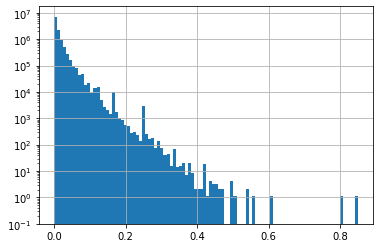

In [12]:
#Plot for weight of investor-investor pair and its counts
fig, ax = plt.subplots()
InvstrInvstrPair_accm["weight"].hist(ax=ax, bins=100, bottom=0.1)
ax.set_yscale('log')

In [13]:
#1st step: reduce degree by threshold
InvstrInvstrPair_reduced = InvstrInvstrPair_accm[InvstrInvstrPair_accm['weight'] > 0.01]

(3945852, 3)

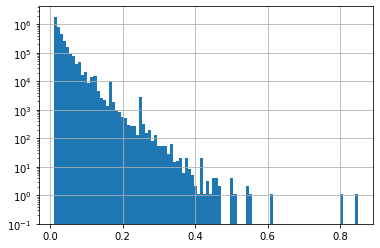

In [14]:
#Again, plot for weight of investor-investor pair and its counts
fig, ax = plt.subplots()
InvstrInvstrPair_reduced["weight"].hist(ax=ax, bins=100, bottom=0.1)
ax.set_yscale('log')
InvstrInvstrPair_reduced.shape

In [15]:
#Save reversed edge list into csv for PageRank.
InvstrInvstrPair_reduced_reversed = InvstrInvstrPair_reduced[['investorID_x', 'investorID_y', 'weight']]
InvstrInvstrPair_reduced_reversed.to_csv("InvInvPairs_reversed.csv", header=False, index=False, sep="\t")

In [16]:
InvstrInvstrPair_reduced_reversed_small = InvstrInvstrPair_reduced_reversed[InvstrInvstrPair_reduced_reversed['weight'] > 0.05]
InvstrInvstrPair_reduced_reversed_small.to_csv("InvInvPairs_reversed_small.csv", header=False, index=False, sep="\t")

In [17]:
#2nd step: select top 15 degree for each node
t = 0
top = 15
for dstID in InvstrInvstrPair_reduced.investorID_x.unique():
    temp = InvstrInvstrPair_reduced[InvstrInvstrPair_reduced["investorID_x"] == dstID]
    if len(temp) > top:
        temp = temp.sort_values("weight", ascending=False,).head(top)
        if t == 0:
            InvstrInvstrPair_top = temp
            t += 1
        else:
            InvstrInvstrPair_top = InvstrInvstrPair_top.append(temp)
    elif t == 0:
        InvstrInvstrPair_top = temp
        t += 1
    else:
        InvstrInvstrPair_top = InvstrInvstrPair_top.append(temp)

         investorID_y  investorID_x    weight
2609059          1248           101  0.125000
591367            318           101  0.125000
2650807          1268           101  0.100000
4627851          2221           101  0.071429
1791258           884           101  0.055556
(82102, 3)


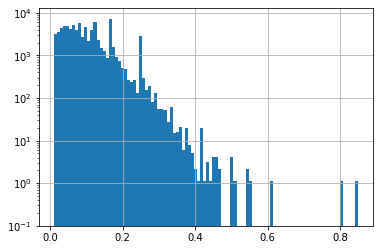

In [18]:
#Again, plot for weight of investor-investor pair and its counts
print(InvstrInvstrPair_top.head())
print(InvstrInvstrPair_top.shape)
fig, ax = plt.subplots()
InvstrInvstrPair_top["weight"].hist(ax=ax, bins=100, bottom=0.1)
ax.set_yscale('log')

In [19]:
#Save edge list into csv for Egonet visualization and HITs.
InvstrInvstrPair_top.to_csv("./data/InvInvPairs.csv", header=False, index=False, sep="\t")

In [20]:
InvstrInvstrPair_top_reversed = InvstrInvstrPair_top[['investorID_x','investorID_y', 'weight']]
InvstrInvstrPair_top_reversed.to_csv("./data/InvInvPairs_top_reversed.csv", header=False, index=False, sep="\t")

In [21]:
#Save investorID/name list into csv.
df_investors[["investorID", "investorname"]].to_csv("./data/Investor.csv", header=False, index=False, sep="\t")